This is adaptation and extension of one of the 100 recipes of the IPython Cookbook.

[IPython Cookbook](http://ipython-books.github.io/), by [Cyrille Rossant](http://cyrille.rossant.net), Packt Publishing, 2014 (500 pages).

A good deal of material has been added to make this suitable for an introductory course.

## Support Vector Machines as classifiers

Let's do some imports.

In [375]:
import numpy as np
import pandas as pd
import sklearn
import sklearn.datasets as ds
from sklearn.model_selection import cross_validate as cv
from sklearn.model_selection import GridSearchCV as gs
import sklearn.svm as svm
import matplotlib as mpl
import matplotlib.pyplot as plt

We generate 2D points and assign a binary label according to a linear operation on the coordinates.

In [407]:
X = np.random.randn(200, 2)
y = X[:, 0] + X[:, 1] > 1

The label is True ("positive") if the sum of the two corrdinates is greater than 1; otherwise False.  This is an easy linear problem.

In [408]:
print(X.shape, X[0,0], X[0,1])
print(y[0])

(200, 2) 0.769110023186096 -1.9182671628192982
False


The values of the coordinates for the first item X[0,:] are shown, as well as the label, computed by the rule given above,

We now fit a linear **Support Vector Classifier** (SVC). This classifier tries to find a line (a line here, more generally a hyperplane) that separates the True labels from the False labels.  Otherwise put, we train the classifier.
The output of training is a decision function that tells us how close to the line we are (close to the boundary means a low-confidence decision).  Positive decision values mean True, Negative decision values mean False.

In [409]:
est = svm.LinearSVC()
est.fit(X, y)

LinearSVC()

For visualization purposes only (specifically, to use the contour plot below), 
we manipulate the data into a "mesh grid"
shape.  We're going to plot decisions for 250000 points in a 250x250 rectangle.
To do that we'll cast the decision results in the same 250x250 meshgrid shape.

In [410]:
# We generate a 1D point sequence x0 of 500 pts in the interval [-3,3 ] on the x-axis 
# and make xx: a 2D 500x500 grid each of whose rows is a copy of x0. 
# yy = xx.T
# The meshgrid is x0 copied 500 times through the interval  [-3,3 ] on the y-axis: total 250,000 pts
# We return the 250,000 x-coordinates and 250,000 y-coordinates
xx, yy = np.meshgrid(np.linspace(-3, 3, 500),
                     np.linspace(-3, 3, 500))

# Flatten the meshgrid so the decision function can operate on the points in it
Z = est.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Put the results back in meshgrid form.
Z = Z.reshape(xx.shape)

In [411]:
print(xx.shape,Z.shape)
print('Four sample points in the grid, first row the x-ordinates, second row the y')

# In the first column of the mesh x is always -3, increases with increasing column index
print(f'{xx[0,0]: 2.3f}, {xx[1,0]: 2.3f}, {xx[0,1]: 2.3f}, {xx[1,1]: 2.3f}')
print(f'{yy[0,0]: 2.3f}, {yy[1,0]: 2.3f}, {yy[0,1]: 2.3f}, {yy[1,1]: 2.3f}')
print()
print('Now the value of the decision function for those points.  It will be a high positive number for high-confidence positive decisions.')
print('It will have a low absolute value (near 0) for low-confidence decisions.')
print('It will change each time you run this notebook, because a new set of random points is chosen on each run.')
print()
print(f'{Z[0,0]: 2.3f}, {Z[0,1]: 2.3f}, {Z[1,0]: 2.3f}, {Z[1,1]: 2.3f}')
print()
print('The real shape of the data in table form is 250000 2 D points, a 250000x2 array')
print(np.c_[xx.ravel(),yy.ravel()].shape)

(500, 500) (500, 500)
Four sample points in the grid, first row the x-ordinates, second row the y
-3.000, -3.000, -2.988, -2.988
-3.000, -2.988, -3.000, -2.988

Now the value of the decision function for those points.  It will be a high positive number for high-confidence positive decisions.
It will have a low absolute value (near 0) for low-confidence decisions.
It will change each time you run this notebook, because a new set of random points is chosen on each run.

-14.757, -14.732, -14.732, -14.707

The real shape of the data in table form is 250000 2 D points, a 250000x2 array
(250000, 2)


We define a function that displays the boundaries and decision function of a trained classifier.  The `scatter` function displays our points on the 2D grid we defined.  We show the regions of the grid where the decision surface `Z` has the highest values in dark blue with `imshow`, and we show the place where `Z` is 0 with the `contour` function, instructing it to draw a black line along the pointss where `z=0`.  The `scatter` function assigns a color to points as well.  Those for which the class value (`y`) is 1 are dark; those with class value 0 are light (open circles).  We draw dashed axis lies with the two `axhline` and `axvline` commands.

In [412]:
# This function takes a trained SVM estimator as input.
def plot_decision_function(est, X0, y, confidence_plot = False, figside=6,bounds=3,
                           kernel=None):
    xx, yy = np.meshgrid(np.linspace(-bounds, bounds, 500),
                         np.linspace(-bounds, bounds, 500))
    # We evaluate the decision function on the grid.
    X = np.c_[xx.ravel(), yy.ravel()]
    if kernel is not None:
        #X = np.c_[X, third_dimension(X)]
        X = kernel(X)
    Z = est.decision_function(X).reshape(xx.shape)
    cmap = plt.cm.Blues
    # This works too
    #cmap = plt.cm.Reds
    # We display the decision function on the grid.
    plt.figure(figsize=(figside,figside));
    toshow = np.abs(Z) if confidence_plot else Z
    # This will color 250K pts according to Z-value
    plt.imshow(toshow,
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                aspect='auto', origin='lower', cmap=cmap);
    # This will display the decision boundary: the boundary where Z = 0  
    plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                colors='k');
    # y is a Boolean array the same size as X.shape[0], giving the class of all plotted pts
    # All point colors c fall in the interval .5<=c<=1.0 on the blue colormap. 
    # We boost color vals to color the true points darker.
    plt.scatter(X0[:, 0], X0[:, 1], s=30, c=.5+.5*y, lw=1, 
                cmap=plt.cm.Reds, vmin=0, vmax=1);
    plt.axhline(0, color='k', ls='--');
    plt.axvline(0, color='k', ls='--');
    plt.xticks(());
    plt.yticks(());
    plt.axis([-3, 3, -3, 3]);

5) Let's take a look at the classification results with the linear SVC.

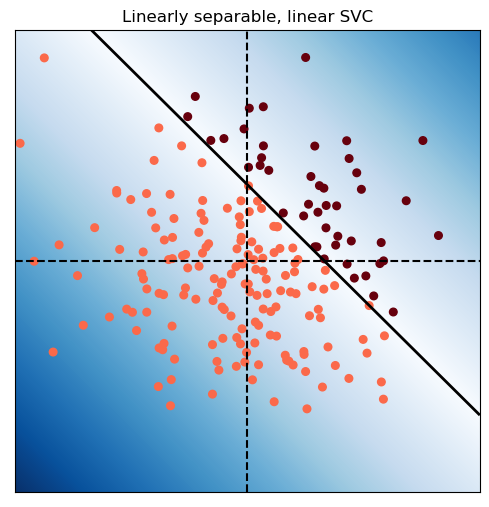

In [413]:
plot_decision_function(est, X, y, confidence_plot = True);
plt.title("Linearly separable, linear SVC");

The linear SVC tried to separate the points with a line and it did a pretty good job.

## A margin

Next we'll take our super-easy classification problem and make it even easier by inserting more distance between the positve and negative instances.  Let's modify our point locations
so that there is a "no man's land" between the positive and negative points.  This demonstrates that the idea of an SVM is not just drawing any linear separator but drawing the one that "maximizes" the "margin" (distance) between the separating plane and the nearest examples.

In the two cells we create a new dataset in which the Xvalues of just the positive points have been increased by 1.

In [414]:
F = np.zeros(len(y),dtype=bool)
print(F[:4])

[False False False False]


How `np.where` works:

In [415]:
a = np.arange(10)
print(a)
np.where(a < 5, a, 10*a)

[0 1 2 3 4 5 6 7 8 9]


array([ 0,  1,  2,  3,  4, 50, 60, 70, 80, 90])

In [416]:
Y = np.c_[y,F]
NX = np.where(Y,X+1,X)

Line 1: We made new `Y` to use as a condition for creating new data.

Second column of Y is always `False`, first is the same as `y`.

Line 2:  Make the new X-data `NX`; leave the Y-coordinate (second column) as before.  add 1 to the corrd of the X's that were `True`.
dave the other X-values as before.

In [417]:
Y[:5]

array([[False, False],
       [False, False],
       [False, False],
       [False, False],
       [False, False]])

In [418]:
print(X[:5])
print()
print(NX[:5])

[[ 0.76911002 -1.91826716]
 [ 0.75154182 -1.43367159]
 [-1.30058099  0.87786408]
 [ 0.34052398  0.45186331]
 [-0.79878613 -0.3480648 ]]

[[ 0.76911002 -1.91826716]
 [ 0.75154182 -1.43367159]
 [-1.30058099  0.87786408]
 [ 0.34052398  0.45186331]
 [-0.79878613 -0.3480648 ]]


The positive negative rule will be the same, the label is True ("positive") if the sum of the two ORIGINAL coordinates is greater than 1; otherwise False.  So we use the same y.

We now fit a linear **Support Vector Classifier** (SVC) to the modified data.

In [419]:
est = svm.LinearSVC(random_state=44)
est.fit(NX, y);

We now define a slightly modified function that displays the boundaries and decision function of a trained classifier, as before, and adds dashed lines to show the margin between the
separating line and the nearest data points.

In [420]:

def new_plot_decision_function(est, X0, y, confidence_plot = False, figside=6,bounds=3):
    xx, yy = np.meshgrid(np.linspace(-bounds, bounds, 500),
                         np.linspace(-bounds, bounds, 500))
    # We evaluate the decision function on the grid
    # flattening the grid out first
    X = np.c_[xx.ravel(), yy.ravel()]
    Z = est.decision_function(X)
    # put Z back into meshgrid form, for ploitting
    Z = Z.reshape(xx.shape)
    cmap = plt.cm.Blues
    # We display the decision function on the grid.
    plt.figure(figsize=(figside,figside));
    toshow = np.abs(Z) if confidence_plot else Z
    plt.imshow(toshow,
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                aspect='auto', origin='lower', cmap=cmap);            
    # We display the boundary where Z = 0
    plt.contour(xx, yy, Z, levels=[-.5,0,.5], linewidths=2,
                colors='k', linestyles=['dashed','solid'])
    # All point colors c fall in the interval .5<=c<=1.0 on the blue colormap. We color the true points darker blue.
    plt.scatter(X0[:, 0], X0[:, 1], s=30, c=0+.5*y, lw=1, 
                cmap=cmap, vmin=0, vmax=1);
    plt.axhline(0, color='k', ls=':');
    plt.axvline(0, color='k', ls=':');
    plt.xticks(());
    plt.yticks(());
    plt.axis([-3, 3, -3, 3]);

5) Let's take a look at the classification results with the linear SVC.

Text(0.5, 1.0, 'Separable with margin, linear SVC')

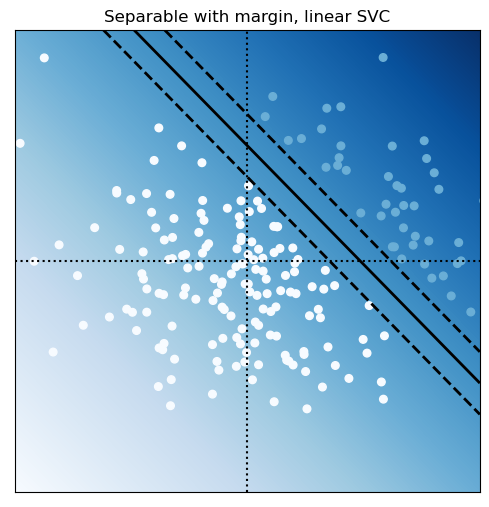

In [421]:
new_plot_decision_function(est, NX, y)
plt.title("Separable with margin, linear SVC")

In support vector machines, the linear separator chosen is the one that **maximizes the
margin** between the separator and the nearest points.  Those points are called the
**support vectors**;  they can also be used to define the separator (we'll do this below).

Aside:   Here's what the different linestyles mean in matplotlib.

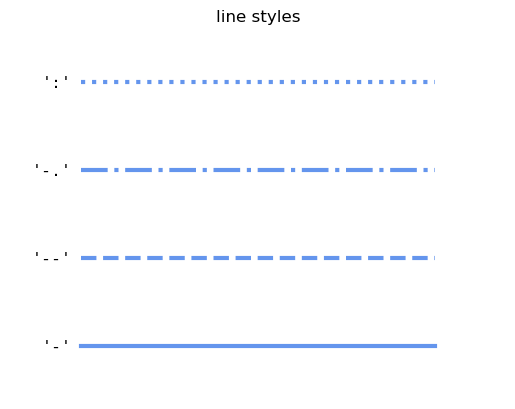

In [404]:
"""
====================
Line-style reference
====================

Reference for line-styles included with Matplotlib.
"""
import numpy as np
import matplotlib.pyplot as plt


color = 'cornflowerblue'
points = np.ones(5)  # Draw 5 points for each line
text_style = dict(horizontalalignment='right', verticalalignment='center',
                  fontsize=12, fontdict={'family': 'monospace'})


def format_axes(ax):
    ax.margins(0.2)
    ax.set_axis_off()


def nice_repr(text):
    return repr(text).lstrip('u')


# Plot all line styles.
fig, ax = plt.subplots()

linestyles = ['-', '--', '-.', ':']
for y, linestyle in enumerate(linestyles):
    ax.text(-0.1, y, nice_repr(linestyle), **text_style)
    ax.plot(y * points, linestyle=linestyle, color=color, linewidth=3)
    format_axes(ax)
    ax.set_title('line styles')

plt.show()

## A non separable example

We now replace the former labels with a **IFF** function. The name name IFF comes from propositional logic.
A proposition that requires $p$ and $q$ to have the same truth value is

$$p \longleftrightarrow q.$$

This is read "$p$ if and only if $q$" (abbreviated "$p$ iff $q$").  

We call the function defined below the
IFF function because a point's label is 1 if the coordinates have the same **signs**. This classification is not linearly separable. Therefore, a linear SVC fails completely.

During training, we get lots of warnings from sklearn.  It's very upset and ultimately
quits without having found a satisfactory separator.

0.615


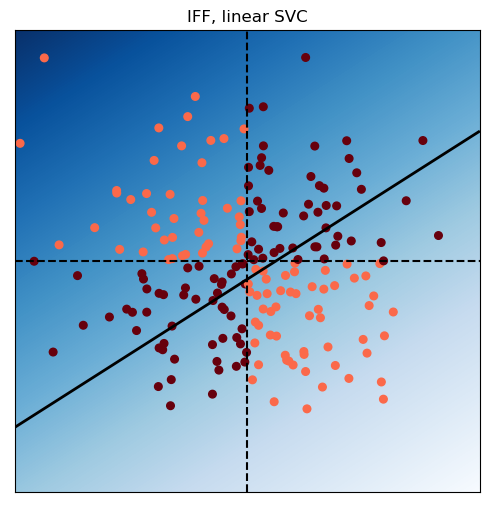

In [424]:
# XOR the x or y coord must be positive, but not both
# y2 = (X[:, 0] * X[:, 1]) > 0
# IFF
y_iff = (X[:, 0] * X[:, 1]) > 0

# We train the classifier. allow a model with some misclassified points.
# 'C' np.logspace(-3., 3., 10)})
est = svm.LinearSVC(random_state=42) 
est.fit(X, y_iff)

# Plot the decision function.
plot_decision_function(est,X, y_iff)
plt.title("IFF, linear SVC")
print(est.score(X,y_iff))

Hmm.  .615 is better than random chance.  Is that just luck?

Or does this clasifier know something?

###  Cross-validation

Different training-test splits will give differemt evaluation results, essentially
because some test sets, however randomly chosen, are harder.

The solution is **n-way cross validation**. Take, for instance,  five-way cross-validation.  Do five training-test splits of the same  data. Each split partitions the entire data set into training and test parts.
Take the mean value of the five evaluations as your final reported score.
But what if some particularly hard subset of the data gets left out in all five splits? 
We won't let that happen.  Start by splitting the data into 5 sets of equal size; on each of the 5 evaluations
leave out of the five parts to use as test data.  So 5-way cross validation means training on
80% of the data, and testing on 20%.  Since each validation run tests on a different 20%,
every item is used as a test item on some validation run.

In [425]:
# We'll do cross validation on the training data, and take mean()
# cv_res is a dict
est = svm.LinearSVC(random_state=43) 
cv_res = cv(est, X, y2)
#cv_res = cv(est, X, y2)
print(f"Score: {cv_res['test_score'].mean():.1f}")

Score: 0.5


As expected with this linearly non seperable problem, the mean score is right at random chance, nn So
previous score score **was** due to luck.

Some of the parameters of our cross validation.

In [426]:
print(cv_res.keys())
# This is cross validation on 5 different runs. Here are the 5 test scores.
print(cv_res['test_score'])
# Maybe a little better than random chance, not sure why...
print(cv_res['test_score'].mean())

dict_keys(['fit_time', 'score_time', 'test_score'])
[0.5   0.525 0.525 0.5   0.475]
0.505


### Grid search plus cross-validation

Classifiers like `SVC` have various parameters that can be set in various ways. 

Usually you won't have a clue what value suits your problem best.
Also, the values of different parameters will interact: Value  0
for parameter 1 and value 0 of parameter 2 may bomb when you test 
them individually, but provide a big boost
in perforamnce when you use them together.

One idea is to use a grid search.  Check out all possible combinations
of values for a set of parameters.  This is called the value
grid for this set of parameters.

Grid search is usually done with more than one feature
but for simplicity we'll use a range of values for one feature `C` (which
controls the penalty for allowing training points to
occur on the wrong side of the margin).

In [427]:
grid = gs(svm.LinearSVC(random_state=45), 
          {'C': np.logspace(-3., 3., 10)});
grid.fit(X, y_iff);


/Users/gawron/opt/anaconda3/envs/p310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gawron/opt/anaconda3/envs/p310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gawron/opt/anaconda3/envs/p310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gawron/opt/anaconda3/envs/p310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gawron/opt/anaconda3/envs/p310/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/gawron/opt/an

In [428]:
# The range of values tried for C
# What logspace does: 10 values evenly log-spaced from 10^{-3} to 10^{3}
# Log-spacing: x_{i} = 10**(-3) * f**i (f app. = 4.64)

LS = np.logspace(-3., 3., 10)
print(LS)
#Winner after grid search: 10^{3}
print(grid.best_params_)

[1.00000000e-03 4.64158883e-03 2.15443469e-02 1.00000000e-01
 4.64158883e-01 2.15443469e+00 1.00000000e+01 4.64158883e+01
 2.15443469e+02 1.00000000e+03]
{'C': 215.44346900318823}


This is the highest value for C in the range, since
of course a very large number of points must
be allowed to lie on the wrong side of the margine.

### The kernel trick

The IFF problem has thus far not been solved.  In fact we seem to have to shown
that no linear classifier can solve it.

Fortunately, it is possible to adapt a linear SVM to a non-linear problem by using non-linear transformations.
This is the strategy we first saw in the case of regression (using polynomial transformations
of the data).  Although finding the polynomial model was still a linear problem,
that price for this greater modeling power was that the data had to be mapped into
a higher-dimension "polynomial" space. Such transformations can sometimes
be made more tractable by using **kernels**,
functions that compute the dot products of the transformed data.

As we'll illustrate below, kernels are appealing because they provide  a way of representing data that has been 
transformed into a higher-dimensional space without explicitly representing the transformation $f$.
Many classification learning algorithms (SVMs are among them) 
can learn the same linear separator using either a kernel
or an explicit higher dimensional representation of $f$ (the two equivalent learning problems
are **duals** of each other).

As an example, let's say that there is feature function ${\mathbf f}$ that
provides a representation of the 2D data in this notebook in 3D, for example.

$$
f: (x,y) \mapsto (x,\,y,\,xy)
$$

Then the Kernel is a function K of two data points $X_{1}$ and $X_{2}$ that 
computes the dot product of their representation under $f$.

$$
\text{K}({X_1},\,X_{2}) = f(X_{1}) \cdot f(X_{2}) = x_{1}x_{2} + y_{1}y_{2} + x_{1}y_{1}x_{2}y_{2}
$$

How does this help with training a classifier?  
Training a  linear classifier means searching for a sequence (or vector) of feature
weights that solve the classification problem.  Writing $c(X)$ as the class assigned to 
example $X$, and $w$ as the vector of feature weights,
the class can be written as the sign of the dot product of the features weights with $X$:

$$(a)\; c(X) = \text{sign}(w\cdot f(X))$$.

What makes the kernel trick useful in a learning setting is  that  $w$ can be decomposed into a weighted sum of $n$ of the transformed examples in the data $(X_{1},\,\dots,\,X_{n})$; for our current purposes it doesn't matter which $n$
examples are used, but
in a support vector machine these are usually chosen from the so-called **support vectors** :

$$ (b)\; w = \sum_{k=1}^{n} s_{k} \, f(X_{k})$$

Then the same classifier can be formulated as:

$$ (c)\; c(X) = \text{sign}(\sum_{k=1}^{n} s_{k} K(X_{k}, X)) $$

>A note for the more mathematically inclined: Given equivalence (b), Using the $n$ support vectors and their weights we have:

>$$(d)\;  c(X) = \begin{array}[t]{l}\text{sign}(\,\sum_{k=1}^{n} s_{k} K(X_{k}, X)\,)\\ \text{sign}(\,\sum_{k=1}^{n} s_{k} f(X_{k}) \cdot f(X)\,) \\ \text{sign}(\,(\,\sum_{k=1}^{n} s_{k} f(X_{k})\,)\cdot f(X)\,)\\ \text{sign}(w\cdot f(X)) \end{array} $$

Using formulation (a), the learner works entirely with the transformed data $f(X)$ and learns feature weights for the transformed (possibly higher dimensional) space.  Using formulation (c), the learner works in the original feature space of $X$ find $n$ support vectors and their weights.   Formulation (c) may be more efficient when $f$ has nasty  computational properties or when there are many features and few examples.

Using formulation (c)  is called the kernel trick. It is a trick because the transformation $f$ is implicit;
classification applies K to support vectors and  $X$, all of which are untransformed.

###  Example (for the mathematically inclined): Using polynomial kernel on IFF problem

As an example consider one of the kernels the scikit-learn `SVC` (Support-Vector Classifier) supports,
the **polynomial kernel**; for our 2D data the polynomial kernel function K with degree = 2 looks like this:

$$
\begin{array}[t]{lcl}
K(X_{1},X_{2}) &=& x_{1}^{2} x_{2}^{2} + 2x_{1} x_{2} y_{1} y_{2} + y_{1}^{2} y_{2}^{2}\\
               &=& (x_{1}^{2}, \sqrt{2}\, x_{1} y_{1}, y_{1}^{2}) \cdot (x_{2}^{2}, \sqrt{2}\, x_{2} y_{2}, y_{2}^{2})
\end{array}
$$

So the feature transformation corresponding to this kernel is:

$$
f: (x,y) \mapsto (x^{2}, \,\sqrt{2}\, x y, \, y^{2}).
$$

This particular kernel is computationally quite attractive because K is just the square of the dot product:

$$
K(X_{1},X_{2}) = (x_{1}x_{2} + y_{1}y_{2})^{2} = (X_{1}\cdot X_{2})^{2}.
$$

So the key characteristics of the kernel trick are very clear.
The transformation $f$ maps a 2D representation into a nonlinear 3D representation (involving 
multiplying feature values $x$ and $y$ and $\sqrt{2}$); while K is just the square of the dot product of 
two 2D feature vectors.

Transformation $f$ provides a very simple linear separator for the 2D IFF problem,
whether we use the kernel trick or not.
Note that feature 2 multiplies feature values $x$ and  $y$; $xy$ will be positive for positive
examples and negative for negative examples, so the following $w$ defines a successful
separator:

$$w = (0,1,0).$$

Working in the 3d feature space of $f$, we classify $(-1,1)$, a negative IFF instance,
as follows:

$$
\begin{array}[t]{lll}
f((-1,\,1)) & = &(1,-\sqrt{2}, 1)\\
\text{sign}(w\cdot f((-1,\,1))) &=& \text{sign}((0,\,1,\,0) \cdot (1,\,-\sqrt{2},\, 1) )\\
                              &=& \text{sign}(-\sqrt{2})\\
                              &=& -1
\end{array}
$$

So this is correctly classified as a negative example.  Next we try positive IFF
instance (-1, -1).

$$
\begin{array}[t]{lll}
f((-1,\,-1)) & = &(1,\, \sqrt{2}, \,1)\\
\text{sign}(w\cdot f((-1,1))) &=& \text{sign}((0,\,1,\,0) \cdot (1,\,\sqrt{2},\, 1) )\\
                              &=& \text{sign}(\sqrt{2})\\
                              &=& 1
\end{array}
$$

And this is correctly classified as a positive example.

Now let's classify the same two examples using the kernel K.
Let's choose $\mathbf{(1,1)}$ and $\mathbf{(1,-1)}$ as our example vectors
(How did we arrive at that choice? The answer is that any linearly independent
vectors would work for our purposes here).  Next we guess at appropriate support weights $s_1$ and $s_2$
(we don't actually have to guess but we omit the computation here):

$$
\begin{array}[t]{l|ccc}
      & v_{i} &  f(v_{i}) & s_{i} \\
      \hline
v_{1} & \mathbf{(1,\,1)} & (1, \,\sqrt{2},\, 1) & \frac{\sqrt{2}}{4}\\
v_{2} & \mathbf{(1,\,-1)} & (1,\, -\sqrt{2}, \,1) & -\frac{\sqrt{2}}{4}\\
\end{array}
$$

Then the weighted sum of the 3D versions of our example vectors
sums to $w$, as desired:

$$
\begin{array}[t]{lll}
w & = & s_{1} f(v_{1})  + s_{2} f(v_{2})\\
  & = & \frac{\sqrt{2}}{4} (1, \sqrt{2}, 1) + - \frac{\sqrt{2}}{4} (1, -\sqrt{2}, 1)  \\
  & = & (\frac{\sqrt{2}}{4}, 1/2, \frac{\sqrt{2}}{4}) + (-\frac{\sqrt{2}}{4}, 1/2, -\frac{\sqrt{2}}{4})  \\
  & = & (0,1,0)
 \end{array}
$$

With the support vectors and their weights in hand, 
we can now apply the Kernel trick to 
classify negative example vector (-1,1)
without using a third dimension (support vectors are in bold):

$$
\begin{array}[t]{lll}
c((-1,1)) &=& \text{sign}(\sum_{k=1}^{n} s_{k} \, K(X_{k}, (-1,1)) \\
          &=& \text{sign}(\sqrt{2}/4 \, (\mathbf{(1,\, 1)} \cdot (-1,\,1))^2 + 
                       -\sqrt{2}/4\, (\mathbf{( 1,\, -1)} \cdot (-1,\,1))^2 )\\
          &=& \text{sign}(\,(\sqrt{2}/4 \cdot 0) + (-\sqrt{2}/4 \cdot (-2)^2 )\,)\\          
          &=& \text{sign}(-\sqrt{2})\\
          &=& -1
\end{array}
$$

So this is again correctly classified as negative. Meanwhile

$$
\begin{array}[t]{lll}
c((-1,\,-1)) &=& \text{sign}(\sum_{k=1}^{n} s_{k} K(X_{k}, (-1,\,-1)) \\
         &=& \text{sign}(\sqrt{2}/4\, (\mathbf{(1,1)} \cdot (-1,\,-1))^2 + 
                   -\sqrt{2}/4\, (\mathbf{(1,\,-1)} \cdot (-1,\,-1))^2 )\\
          &=& \text{sign}(\,(\sqrt{2}/4 \cdot (-2)^2) + (-\sqrt{2}/4 \cdot 0)\,)\\          
          &=& \text{sign}(\sqrt{2})\\
          &=& 1
\end{array}
$$

And this is again correctly classified as positive.

Let's try scikit_learn's polynomial kernel on the IFF problem using  `svm.SVC`.

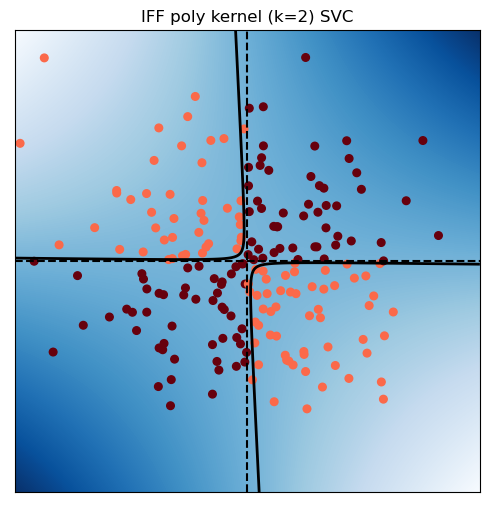

In [432]:

clf = svm.SVC(kernel='poly',degree=2).fit(X,y_iff)
plot_decision_function(clf,X,y_iff);
plt.title("IFF poly kernel (k=2) SVC");

The kernel-aided SVC does a pretty good job at classifying these non-linearly separable points.

## A simple example of hand-rolled higher dimensionality

A new plotting function

In [275]:
# This function takes a trained SVM estimator as input.
def plot_with_mapping(est, X0, y, mapping, confidence_plot = False, figside=6,bounds=3,
                           ):
    xx, yy = np.meshgrid(np.linspace(-bounds, bounds, 500),
                         np.linspace(-bounds, bounds, 500))
    # We evaluate the decision function on the grid.
    X = np.c_[xx.ravel(), yy.ravel()]
    newX = mapping(X)
    newX0 = mapping(X0)
    est.fit(newX0,y)
    Z = est.decision_function(newX).reshape(xx.shape)
    cmap = plt.cm.Blues
    # This works too
    #cmap = plt.cm.Reds
    # We display the decision function on the grid.
    plt.figure(figsize=(figside,figside));
    toshow = np.abs(Z) if confidence_plot else Z
    # This will color 250K pts according to Z-value
    plt.imshow(toshow,
                extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                aspect='auto', origin='lower', cmap=cmap);
    # This will display the decision boundary: the boundary where Z = 0  
    plt.contour(xx, yy, Z, levels=[0], linewidths=2,
                colors='k');
    # y is a Boolean array the same size as X.shape[0], giving the class of all plotted pts
    # All point colors c fall in the interval .5<=c<=1.0 on the blue colormap. 
    # We boost color vals to color the true points darker.
    plt.scatter(X0[:, 0], X0[:, 1], s=30, c=.5+.5*y, lw=1, 
                cmap=plt.cm.Reds, vmin=0, vmax=1);
    plt.axhline(0, color='k', ls='--');
    plt.axvline(0, color='k', ls='--');
    plt.xticks(());
    plt.yticks(());
    plt.axis([-3, 3, -3, 3]);

Now let's try classifying without the kernel trick simply by passing
the learner the 3D representation given by $f$:

Here is $f$, which maps from a 2D X to a 3D X using the polynomial
feature transformation descriobed in the example above:

$$
f: (x,y) \mapsto (x^{2}, \,\sqrt{2}\, x y, \, y^{2}).
$$

In [465]:
def f (X):
    # The polynomial feature mapping f from our example: "Using polynomial kernel on IFF problem"
    return np.concatenate([X[:,0:1]**2, np.sqrt(2) * X[:,0:1] * X[:,1:2], X[:,1:2]**2], axis=1)

X = np.random.randn(200, 2)

newX = f(X)
## Before and after samples

print('Before')
print(X.shape)
print()
print(X[5:7,:])
print()
print('After')
print(newX.shape)
print()
print(newX[5:7])


Before
(200, 2)

[[-1.13821589 -1.25465211]
 [ 1.40494602 -0.44130411]]

After
(200, 3)

[[ 1.29553541  2.01958884  1.57415191]
 [ 1.97387332 -0.87682437  0.19474932]]


In the next cell, we train on the transformed with the same classification rule as before.
    No kernel trick (`dual=False`).

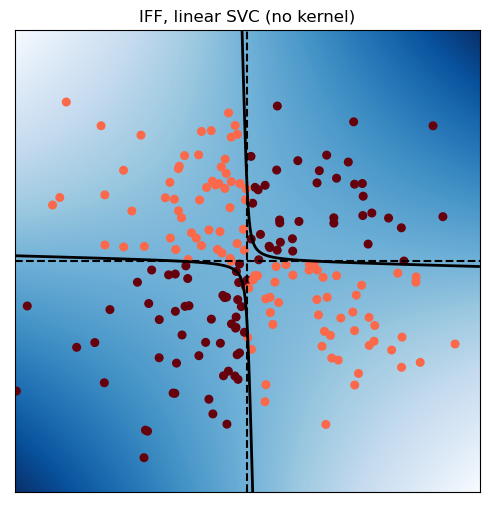

In [466]:
# Same rule as before
#y = (newX[:, 0] > 0) ^ (newX[:, 1] > 0)

y = X[:,0] * X[:,1] > 0
# Calling LinearSVC to build a model with no Kernel (dual=False)
# Not an option with SVC.
est = svm.LinearSVC(random_state=42,dual=False)
#  This functions trains the classifier
#  Tell the plotter it needs to use kernel f
plot_with_mapping(est, X, y, mapping=f);
plt.title("IFF, linear SVC (no kernel)");

This picture looks a lot like the picture we
drew using `SVC` and a kernel, but there are important
differences.  In this case we have two versions
of the training data: X (points in 2D space) and f(X)
(points in 3D space used in a polynomial model).  The scatterplot shows X.
The color values represent the class assigned by the trained
classifier to those points.

The classifier trains and predicts on f(X), so it has a 3D problem.
In a 3D problem, the linear separator is a plane.
In our problem, the SVM classifier needs to find a plane 
that separates the IFF points from the non-IFF points. 
Z (as used in the code) is the confidence value assigned
by the classifier; it is positive when the class of a point is positive
(the dark orange points), and
negative when the class is negative (the light orange points);
so the plane plane that exactly
seaparates the positive points from the negative
ones is the XY plane.  In other words, with our data X represented as f(X),
the XY plane is precisely the linear separator we're
looking for.

The thing that is hard to visualize in the 2D picture is how
the curve that separates the positive points from
the negative points comes about. In particular, how
is it created by a linear separator, in fact, a plane, in
fact, the xy-plane?  The answer is that the curved separator
depicts the points in the decision function Z
where Z = 0.  The decision function Z is actually a curved surface
and it so happens that its intersection with the xy-plane
is the curved black line in the picture above.

We show the decision surface in the next plot, which is 3D.
As we demonstrated in discussing the discussion of example
points in the poynomial kernel, for the IFF problem
the only feature that receives a non-zero weight
is the $\sqrt{2}xy$ feature, so the decision function
is essentially a plot of this function, possibly scaled differently.  The red points are positive Z;
the blue points are negative.   The further away from the origin
a point is, the higher its Z-value, positive or negative.

ax.azim=120
ax.elev=-140


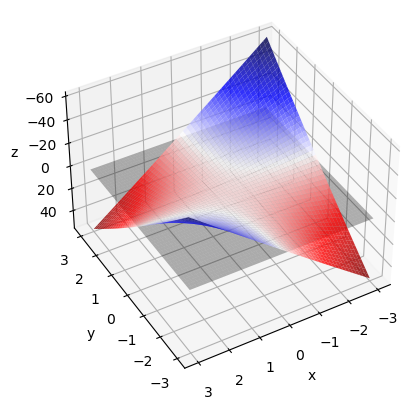

In [371]:
#def f(x, y):
#    return x*y

X0 = np.random.randn(200, 2)
y = X0[:,0] * X0[:,1] > 0
newX0 = f(X0)
est = svm.LinearSVC(random_state=42,dual=False)
est.fit(newX0,y)

bounds=3
xx, yy = np.meshgrid(np.linspace(-bounds, bounds, 500),
                     np.linspace(-bounds, bounds, 500))
X = np.c_[xx.ravel(), yy.ravel()]
newX = f(X)
Z = est.decision_function(newX).reshape(xx.shape)
    

#x = np.linspace(-3, 3, 500)
#y = np.linspace(-3, 3, 500)

#X, Y = np.meshgrid(x, y)
#Z = f(X, Y)
#Z2 = f2(X,Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(xx, yy, Z,
             cmap='seismic', edgecolor='none',alpha=.8)

#print('ax.azim {}'.format(ax.azim))
#print('ax.elev {}'.format(ax.elev))
#ax.plot_surface(X, Y, Z2, rstride=10, cstride=10,
#                cmap='Greys_r', edgecolor='none',
#                alpha=.4)
#print(f'{ax.azim=}')
#print(f'{ax.elev=}')
ax.plot_surface(xx, yy, np.zeros(Z.shape), rstride=10, cstride=10,
                cmap='Greys_r', edgecolor='none',
                alpha=.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
#Default vals
#ax.elev 30; ax.azim -60
elev,azim = 30, -60
#elev,azim = 25, 80
#ax.view_init(elev,azim)
#ax.view_init(-140, 60)  # From above
#ax.view_init(-140, 90)  # From ??
ax.view_init(-140, 120)  # From ??
print(f'{ax.azim=}')
print(f'{ax.elev=}')

The same surface at a different scale, drawn with the equation

$$
z = \sqrt{2} xy.
$$

ax.azim=-60
ax.elev=30
ax.azim=30
ax.elev=-180


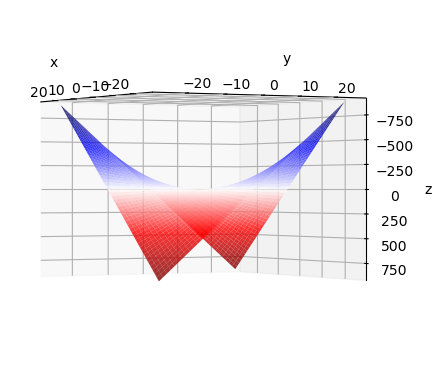

In [374]:
fig = plt.figure()
ax = plt.axes(projection='3d')
bounds=25
xx, yy = np.meshgrid(np.linspace(-bounds, bounds, 500),
                     np.linspace(-bounds, bounds, 500))
Z = np.sqrt(2) * xx * yy
ax.plot_surface(xx, yy, Z,
             cmap='seismic', edgecolor='none',alpha=.8)

#print('ax.azim {}'.format(ax.azim))
#print('ax.elev {}'.format(ax.elev))
#ax.plot_surface(X, Y, Z2, rstride=10, cstride=10,
#                cmap='Greys_r', edgecolor='none',
#                alpha=.4)
print(f'{ax.azim=}')
print(f'{ax.elev=}')
ax.plot_surface(xx, yy, np.zeros(Z.shape), rstride=10, cstride=10,
                cmap='Greys_r', edgecolor='none',
                alpha=.3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
ax.view_init(-180, 30)  # From ??
print(f'{ax.azim=}')
print(f'{ax.elev=}')

### Sometimes the polynomial feature mapping is a bad idea

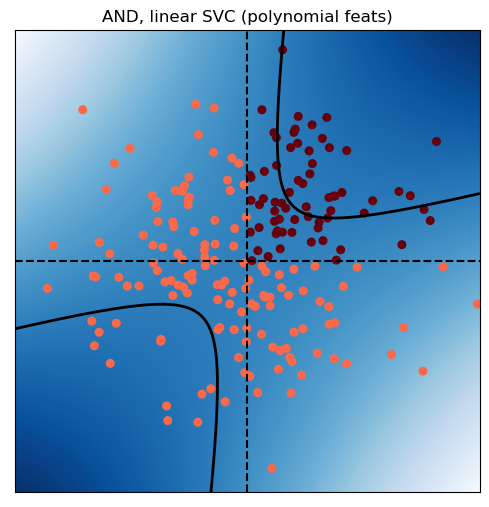

In [436]:
#AND  Just points in the first quadrant are positive.
X0 = np.random.randn(200, 2)
y = (X0[:,0] > 0) & (X0[:,1] > 0)

def f (X):
    # The polynomial feature mapping f from our example: "Using polynomial kernel on IFF problem"
    return np.concatenate([X[:,0:1]**2, np.sqrt(2) * X[:,0:1] * X[:,1:2], X[:,1:2]**2], axis=1)

newX = f(X0)
est = svm.LinearSVC(random_state=42,dual=False)
est.fit(newX,y)
plot_with_mapping(est, X0, y, mapping=f);
plt.title("AND, linear SVC (polynomial feats)");

Here the feature mapping is truly unsuited to the problem:

$$
f: (x,y) \mapsto (x^{2}, \,\sqrt{2}\, x y, \, y^{2}),
$$

for example, maps both (-3,-4) and and (3,4) to the same point,
so it erases a distinction we need to make.

Of course since the data are not linearly
separable, the learner with no feature mapping fails as well, perhaps less spectacularly.

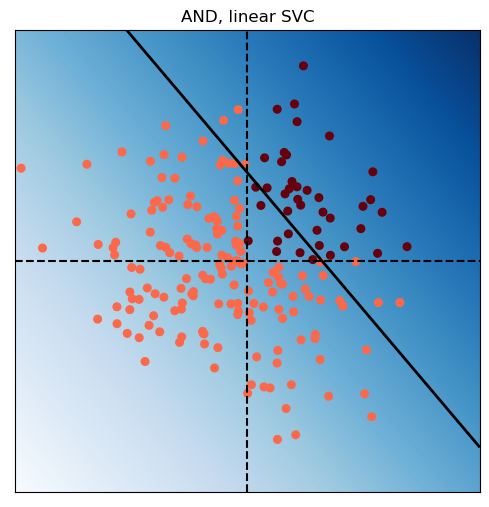

In [358]:
X0 = np.random.randn(200, 2)
y = (X0[:,0] > 0) & (X0[:,1] > 0)

est = svm.LinearSVC(random_state=42,dual=False)
est.fit(X0,y)

plot_decision_function(est, X0, y)
plt.title("AND, linear SVC");

In this case another kernel, the RBF kernel, succeeds.

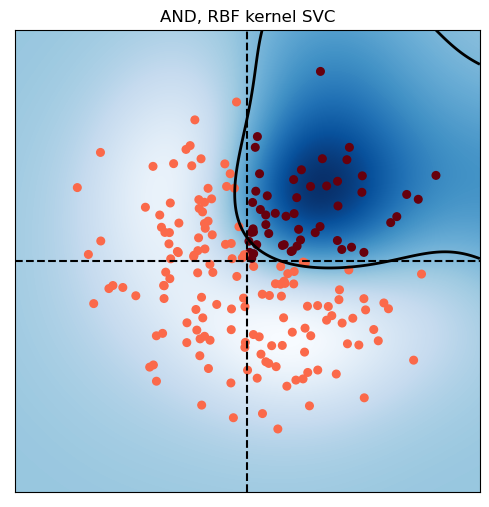

In [437]:
X0 = np.random.randn(200, 2)
y = (X0[:,0] > 0) & (X0[:,1] > 0)

#est = svm.LinearSVC(random_state=42,dual=False)

est = svm.SVC(kernel="rbf").fit(X0,y)

est.fit(X0,y)

plot_decision_function(est, X0, y)
plt.title("AND, RBF kernel SVC");

This is a Gaussian kernel:

$$
\text{K}(u, v) = \exp(\,− \vert\negthinspace\vert\, f(u) − f(v)\,\vert\negthinspace\vert ^{2}\,)
$$

It turns out that the corresponding feature
representation for this Kernel is infinite-dimensional.
Quite clearly,  the Kernel representation
is easier to compute with. So the bottom line on kernels 
is that they may make it feasible to compute with
feature representations with large numbers
of features, or even an infinite number of features.